In [1]:
%matplotlib notebook

import datetime
import random
#import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6.0, 4.0)

import load_hats

start_day, end_day = '2016-04-01', '2018-05-31'

In [2]:
def read_met(site, yyyy):
    met_ftp = f'/aftp/met/{site}/'
    met_file = f'met_{site}_insitu_1_obop_hour_{yyyy}.txt'
    df = pd.read_csv(met_ftp+met_file, 
                delim_whitespace=True,
                names=['site','year','month','day','hour','wind_dir','wind_speed','wind_steady','press','temp2','temp10','jj','jk','jl'],
                parse_dates = {'date':[1,2,3,4]},
                infer_datetime_format=True,
                index_col='date',
                na_values=['-999.9', '-999', '-99']
                )
    df.drop(['temp2','temp10','jj','jk','jl'], axis=1, inplace=True)
    return df

<h1>Load NOAA met data

In [3]:
dfs = []
for y in [2016, 2017, 2018]:
    df = read_met('smo', y)
    dfs.append(df)
met = pd.concat(dfs, axis=0)
met = met[start_day:end_day]

In [4]:
met.head()

,site,wind_dir,wind_speed,wind_steady,press
date,,,,,
2016-04-01 00:00:00,SMO,321.0,4.7,90,1001.08
2016-04-01 01:00:00,SMO,295.0,3.0,98,1000.72
2016-04-01 02:00:00,SMO,311.0,1.6,89,1000.22
2016-04-01 03:00:00,SMO,311.0,2.5,97,1000.27
2016-04-01 04:00:00,SMO,311.0,3.4,99,1000.60


<h1>Load CATS data

In [5]:
cats = load_hats.CATS_FTP()
brw = cats.hourly('f11', 'smo')
brw = brw[start_day:end_day].dropna()

In [6]:
brw.head()

,smo_mr,smo_sd
date,,
2016-04-01 00:53:00,230.113,0.95
2016-04-01 01:53:00,230.759,0.95
2016-04-01 02:54:00,229.146,0.95
2016-04-01 03:54:00,229.022,0.95
2016-04-01 04:54:00,228.995,0.95


<h2>Merge dataframes and interpolate wind speed and direction

In [7]:
full = pd.concat([brw, met], axis=1)
full['wind_dir'] = full.wind_dir.interpolate()
full['wind_speed'] = full.wind_speed.interpolate()
full = full.drop(['site', 'wind_steady', 'press'], axis=1).dropna()
full.head()

,smo_mr,smo_sd,wind_dir,wind_speed
date,,,,
2016-04-01 00:53:00,230.113,0.95,308.0,3.85
2016-04-01 01:53:00,230.759,0.95,303.0,2.30
2016-04-01 02:54:00,229.146,0.95,311.0,2.05
2016-04-01 03:54:00,229.022,0.95,311.0,2.95
2016-04-01 04:54:00,228.995,0.95,309.0,3.25


<h3>Remove low wind speeds less than 3 m/s

In [8]:
clean = full.loc[full.wind_speed>3]

Text(0, 0.5, 'CFC-11 (ppt)')

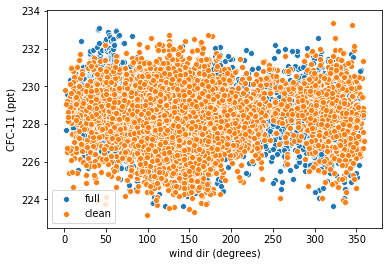

In [10]:
sns.scatterplot(full.wind_dir, full.smo_mr, label='full')
sns.scatterplot(clean.wind_dir, clean.smo_mr, label='clean')
plt.legend()
plt.xlabel('wind dir (degrees)')
plt.ylabel('CFC-11 (ppt)')

,smo_mr,smo_sd,wind_dir,wind_speed
date,,,,
2016-04-01 00:53:00,230.113,0.950,308.0,3.85
2016-04-01 04:54:00,228.995,0.950,309.0,3.25
2016-04-01 15:56:00,229.602,0.934,111.0,4.15
2016-04-01 16:57:00,229.422,0.934,138.5,4.10
2016-04-01 21:58:00,231.060,0.849,140.5,3.90


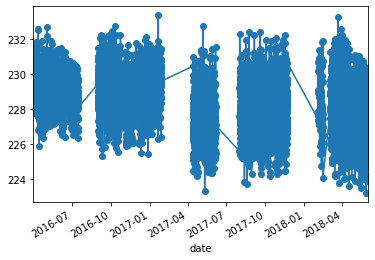

In [11]:
clean.smo_mr.plot(marker='o')
clean.head()

In [12]:
print(f"Number of measurements full:{full.shape[0]} clean:{clean.shape[0]}")

Number of measurements full:12863 clean:9284


<h2>Select random daily sample

In [13]:
df = clean.reset_index()
random.seed(995)
rnd = df.groupby(clean.index.date).apply(lambda x :x.iloc[random.choice(range(0,len(x)), )])

In [14]:
rnd.head()

,date,smo_mr,smo_sd,wind_dir,wind_speed
2016-04-01,2016-04-01 23:58:00,228.993,0.849,160.5,3.70
2016-04-02,2016-04-02 09:00:00,230.446,0.825,121.0,4.00
2016-04-03,2016-04-03 01:04:00,228.617,0.755,37.0,4.00
2016-04-04,2016-04-04 13:12:00,228.841,0.740,358.0,4.95
2016-04-05,2016-04-05 15:07:00,230.515,0.768,328.0,7.25


In [15]:
rnd.set_index(rnd.date, inplace=True)
rnd.drop(['date'], axis=1, inplace=True)
del df

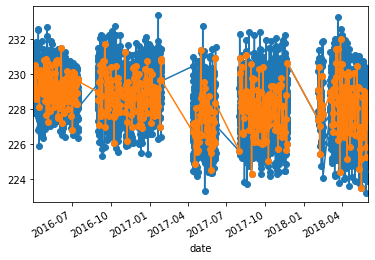

In [16]:
clean.smo_mr.plot(marker='o')
rnd.smo_mr.plot(marker='o')

In [17]:
print(f"Number of measurements full:{full.shape[0]} daily:{rnd.shape[0]}")

Number of measurements full:12863 daily:498


In [18]:
full.to_csv('smo-full.csv')
rnd.to_csv('smo-random-daily.csv')